[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/src/Prediction_Test_Xception_A3F1P3_vs_A3F5P3.ipynb)

In [0]:
# Import library
import os
import glob


In [3]:
# Mount google drive

from google.colab import drive

drive.mount('/content/gdrive')
os.listdir('gdrive/My Drive/Colab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['Model', 'Data']

In [20]:
from keras.models import load_model

# Set model path

modelPath = 'gdrive/My Drive/Colab/Model'

dataPath = 'gdrive/My Drive/Colab/Data'

modelList = glob.glob(modelPath + '/*h5')
    
numberModel = np.inf
    
while numberModel >= len(modelList): 

    for i in range(len(modelList)):
        print('#{:d}: {}'.format(i, modelList[i]))
    
    numberModel = int(input('Type In Your Model Number:\n'))

    if numberModel < len(modelList):
        print('Loading {}'.format(modelList[numberModel]))    
        model = load_model(modelList[numberModel])
        print('Loading Completed')    
    else:
        print('Invalid Model Number\n')
        


#0: gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_Xception_10-06-17:14:18.h5
#1: gdrive/My Drive/Colab/Model/A3F1P3 vs A3F5P3 ResNet50 10-06 05:30:50.h5
Type In Your Model Number:
2
Invalid Model Number

#0: gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_Xception_10-06-17:14:18.h5
#1: gdrive/My Drive/Colab/Model/A3F1P3 vs A3F5P3 ResNet50 10-06 05:30:50.h5
Type In Your Model Number:
0
Loading gdrive/My Drive/Colab/Model/A3F1P3-A3F5P3_Xception_10-06-17:14:18.h5
Loading Completed


In [54]:
creationDate = modelList[numberModel].split('_')[-1].replace('.h5', '')

modelParamList = glob.glob(modelPath + '/*.npy')
modelParam = [param for param in modelParamList if creationDate in param]

print('Parameter npy File List: {}'.format(modelParam))

trainMean = float(np.load([param for param in modelParam if 'mean' in param][0]))
trainStd = float(np.load([param for param in modelParam if 'std' in param][0]))

Parameter npy File List: ['gdrive/My Drive/Colab/Model/std_10-06-17:14:18.npy', 'gdrive/My Drive/Colab/Model/mean_10-06-17:14:18.npy']


In [55]:
dataPath = 'gdrive/My Drive/Colab/Data'

foldersTest = ['A3F2P3', 'A3F3P3', 'A3F4P3']

pathTests = [dataPath + '/' + folder for folder in foldersTest]
print(pathTests)

filesTest = list()

for i in range(len(foldersTest)):
    filesTest = filesTest + (glob.glob(pathTests[i] + '/*.wav'))
    
print(len(filesTest))

['gdrive/My Drive/Colab/Data/A3F2P3', 'gdrive/My Drive/Colab/Data/A3F3P3', 'gdrive/My Drive/Colab/Data/A3F4P3']
3000


In [56]:
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf

nsc = 1470
nov = nsc/2
nff = nsc

imgSize = 224

imgsTestList = list()

for i in range(len(pathTests)):

    npyTestPath = glob.glob(pathTests[i] + '/' + '*.npy')
    
    if (len(npyTestPath) == 1):
        imgsTest = np.load(npyTestPath[0])

    else:
        
        filesTest = glob.glob(pathTests[i] + '/*.wav')
        
        imgsTest = np.zeros([len(filesTest), imgSize, imgSize])

        for j in trange(len(filesTest)):
            fs, dataInt16 = wf.read(filesTest[j])
            dataFloat = dataInt16 / (2 ** 15)
            Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                               window=np.hamming(nsc), cmap='viridis')
            plt.close()
            imgsTest[j, :, :] = 10 * np.log10(Pxx[0:imgSize, :])

        np.save(pathTests[i] + '/' + foldersTest[i] + '.npy', imgsTest)

    print('Test Image Shape From {}: {}'.format(foldersTest[i], imgsTest.shape))    
    
    imgsTestList.append(imgsTest)
    
imgsTestTotal = np.vstack(imgsTestList)

print('Test Image Shape From {}: {}'.format(foldersTest, imgsTestTotal.shape))    
    

Test Image Shape From A3F2P3: (1000, 224, 224)
Test Image Shape From A3F3P3: (1000, 224, 224)
Test Image Shape From A3F4P3: (1000, 224, 224)
Test Image Shape From ['A3F2P3', 'A3F3P3', 'A3F4P3']: (3000, 224, 224)


In [0]:
# Add saving mean and std with model

testImgsNorm = (imgsTestTotal - trainMean) / trainStd

testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)


In [59]:
Y_pred = model.predict(X_test, verbose=1)

3000/3000 [==============================] - 43s 14ms/step


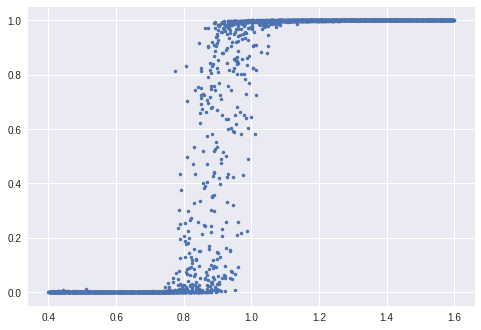

In [63]:
X_ticks = np.zeros(len(Y_pred))

for i in range(len(X_ticks)):
    X_ticks[i] = float(filesTest[i].split('/')[-1].split('_')[1][1:-1])
    

plt.plot(X_ticks, Y_pred[:, 1], '.')

# Need to match file name with x axis

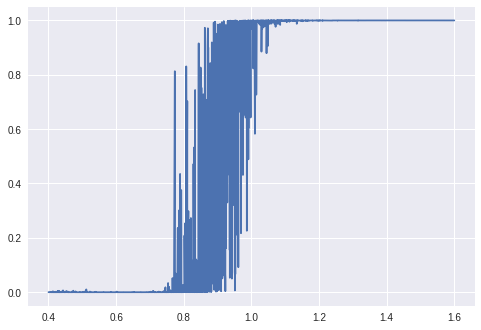

In [61]:
from operator import itemgetter

x = np.stack((X_ticks, Y_pred[:, 1])).T
y = np.asarray(sorted(x, key=lambda x: x[0]))
# plt.plot(x[:, 0], x[:, 1])
plt.plot(y[:, 0], y[:, 1])